In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def drop_ap(csv):
    number = csv.ap_id.value_counts()
    ap_to_drop = number[number < 2000].index
    idx = csv[csv['ap_id'].isin(list(ap_to_drop))].index
    droped_csv = csv.drop(idx).reset_index(drop=True)
    return droped_csv 

In [3]:
def smooth_signal(csv_list):
    """ Smoothing signal of each Access Point with Exponential Weighted Moving Average """
    for csv in csv_list:
        ap_list = list(csv.ap_id.unique())
        for ap in ap_list:
            cut = csv.loc[csv.ap_id == ap]
            cut.rssi = cut.rssi.ewm(span=100, min_periods=0).mean()
            csv.update(cut)

In [4]:
def binning(data_to_parse):
    data = data_to_parse.copy()
    data['level'] = 0
    rooms = list(data.room_id.unique())
    points = list(data.ap_id.unique())
    for room in rooms:
        for ap in points:
            cut = data.loc[(data.ap_id == ap) & (data.room_id == room)]
            cut['level'] = pd.qcut(cut.rssi, q=3, labels=['Low','Medium','High'])
            data.update(cut)
    return data

In [47]:
def category_encoding(data_to_encode):
    data = data_to_encode.copy()
    room_encoder, ap_encoder = LabelEncoder(), LabelEncoder()
    level_mapper = {'Low': 1, 'Medium': 2, 'High': 3}
    data.room_id = room_encoder.fit_transform(data.room_id)
    data.ap_id = ap_encoder.fit_transform(data.ap_id)
    if 'level' in data:
        data.level = data.level.map(level_mapper).astype(np.int32)
    return data, room_encoder 

In [48]:
def data_split(data_to_split):
    data = data_to_split.copy()
    target = data.pop('room_id').values
    features = data.values
    """ Splitting data into train, validation and test """
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.1)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [79]:
def xgb_train(x_train, y_train):
    model = XGBClassifier(objective='multi:softmax', n_estimators=3000, learning_rate=0.01, min_child_weight=2, max_depth=10,
                        gamma=1, verbosity=0)
    print('Training...')
    model.fit(x_train, y_train)
    print('Training done!')
    return model

In [50]:
def evaluate(x,y, model):
    pred = model.predict(x)
    accuracy = accuracy_score(y, pred)
    f1 = f1_score(y, pred, average='macro')
    print('Accuracy: {:.3f}'.format(accuracy))
    print('F1 score: {:.3f}'.format(f1))

In [80]:
file_list = os.listdir('../src/data/')
data_list = [pd.read_csv(f'../src/data/{file}') for file in file_list]
raw_data = pd.concat(data_list).reset_index(drop=True)

In [81]:
#smooth_signal(data_list)
data = pd.concat(data_list).reset_index(drop=True)
parsed_data = drop_ap(data)
feature_data = binning(parsed_data)

In [82]:
encoded_data, room_encoder = category_encoding(feature_data)

In [83]:
x_train, x_valid, x_test, y_train, y_valid, y_test = data_split(encoded_data)

In [84]:
model = xgb_train(x_train, y_train)

Training...
Training done!


In [85]:
evaluate(x_train, y_train, model)

Accuracy: 0.613
F1 score: 0.605


In [86]:
evaluate(x_valid, y_valid, model)

Accuracy: 0.585
F1 score: 0.582


In [87]:
evaluate(x_test, y_test, model)

Accuracy: 0.607
F1 score: 0.613


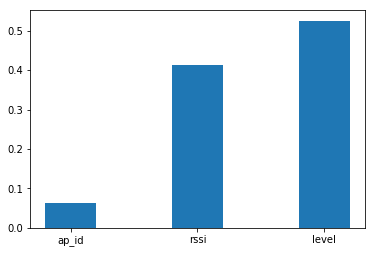

In [88]:
features = encoded_data.copy()
y = features.pop('room_id')
pd.DataFrame(model.feature_importances_.reshape(1, -1), columns=features.columns)
plt.bar(features.columns, model.feature_importances_, width=0.4);

In [89]:
cut = encoded_data[5010:5020] # Data for room "2"
y = cut.pop('room_id').values
x = cut.values

In [90]:
prediction = model.predict(x)
counts = np.bincount(prediction)
print('Prediction:', np.argmax(counts))

Prediction: 2


In [91]:
prediction

array([2, 5, 5, 2, 5, 2, 2, 2, 2, 2])

In [61]:
def cm_dataframe(pred_arr, y, room_encoder):
    """ Calculates Confusion Matrix and makes DataFrame for plotting it """
    encoded_labels = [i for i in range(len(os.listdir('../src/data/')))]
    labels = room_encoder.inverse_transform(encoded_labels)
    cm = confusion_matrix(y, pred_arr)
    df_cm = pd.DataFrame(cm, index=[i for i in labels],
                         columns=[i for i in labels])
    return df_cm

In [70]:
def plot_cm(x, y, model, room_encoder):
    plt.figure(figsize=(8,6))
    pred = model.predict(x)
    df_cm = cm_dataframe(pred, y, room_encoder)
    sn.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

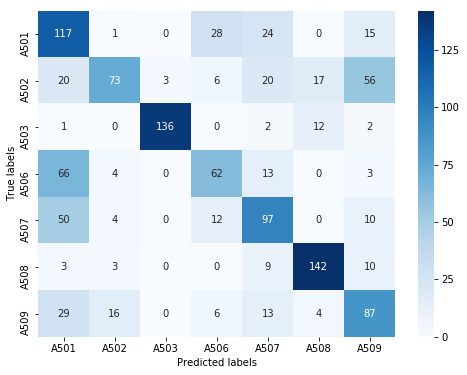

In [92]:
plot_cm(x_test, y_test, model, room_encoder)